# 1. Introduction

The data is available as two attached CSV files:
* takehome_user_engagement.csv
* takehome_users.csv

The data has the following two tables:
* 1] A user table ( "takehome_users" ) with data on 12,000 users who signed up for the product in the last two years. This table includes:
    * name: the user's name
    * object_id: the user's id
    * email: email address
    * creation_source: how their account was created. 
    This takes on one of 5 values:
        * PERSONAL_PROJECTS: invited to join another user's personal workspace
        * GUEST_INVITE: invited to an organization as a guest
        (limited permissions)
        * ORG_INVITE: invited to an organization (as a full member)
        * SIGNUP: signed up via the website
        * SIGNUP_GOOGLE_AUTH: signed up using Google Authentication (using a Google email account for their login id)
    * creation_time: when they created their account
    * last_session_creation_time: unix timestamp of last login
    * opted_in_to_mailing_list: whether they have opted into receiving marketing emails
    * enabled_for_marketing_drip: whether they are on the regular marketing email drip
    * org_id: the organization (group of users) they belong to
    * invited_by_user_id: which user invited them to join (if applicable).


* 2] A usage summary table ( "takehome_user_engagement" ) that has a row for each day that a user logged into the product. Defining an "adopted user" as a user who has logged into the product on three separate days in at least one sevenday period , identify which factors predict future user adoption. 

We suggest spending 12 hours on this, but you're welcome to spend more or less.Please send us a brief writeup of your findings (the more concise, the better no more than one page), along with any summary tables, graphs, code, or queries that can help
us understand your approach. Please note any factors you considered or investigation
you did, even if they did not pan out. Feel free to identify any further research or data
you think would be valuable.

# 2. Import tools and dataset

In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

sns.set()

/Users/justin/anaconda3/lib/python3.7/site-packages/tqdm/std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


Drip marketing is a communication strategy that sends, or "drips," a pre-written set of messages to customers or prospects over time. These messages often take the form of email marketing, although other media can also be used.

In [27]:
# got an utf-8 encoding warning, solved by putting encoding='cp1252'!

df = pd.read_csv('takehome_users.csv', encoding='cp1252')
df.set_index('creation_time')

,object_id,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
creation_time,,,,,,,,,
2014-04-22 03:53:30,1,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
2013-11-15 03:45:04,2,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2013-03-19 23:14:52,3,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
2013-05-21 08:09:28,4,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
2013-01-17 10:14:20,5,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0
...,...,...,...,...,...,...,...,...,...
2013-09-06 06:14:15,11996,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,1.378448e+09,0,0,89,8263.0
2013-01-10 18:28:37,11997,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1.358275e+09,0,0,200,NaN
2014-04-27 12:45:16,11998,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1.398603e+09,1,1,83,8074.0


2] A usage summary table ( "takehome_user_engagement" ) that has a row for each day that a user logged into the product. Defining an "adopted user" as a user who has logged into the product on three separate days in at least one sevenday period , identify which factors predict future user adoption.

Since the project want us to define who is adopted user, the first thing is to extract all these adopted users from the second dataset, and then marked them on the first data set.

In [28]:
usage = pd.read_csv('takehome_user_engagement.csv', index_col=False)

In [29]:
usage.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [45]:
new_usage = usage.groupby(['user_id', 'time_stamp', 'visited']).size().to_frame(name='count').reset_index()

In [46]:
new_usage.head(10)

,user_id,time_stamp,visited,count
0,1,2014-04-22 03:53:30,1,1
1,2,2013-11-15 03:45:04,1,1
2,2,2013-11-29 03:45:04,1,1
3,2,2013-12-09 03:45:04,1,1
4,2,2013-12-25 03:45:04,1,1
5,2,2013-12-31 03:45:04,1,1
6,2,2014-01-08 03:45:04,1,1
7,2,2014-02-03 03:45:04,1,1
8,2,2014-02-08 03:45:04,1,1
9,2,2014-02-09 03:45:04,1,1


use to_datetime to calculate the interval and then use .days to turn it into string to filter out the users who login in 3 times in a week.

In [59]:
active_user=[]

for i in tqdm(range(0, len(new_usage)-2)):
    if ((new_usage.user_id.iloc[i]==new_usage.user_id.iloc[i+1]==new_usage.user_id.iloc[i+2])&\
    ((pd.to_datetime(new_usage.time_stamp.iloc[i+2])-pd.to_datetime(new_usage.time_stamp.iloc[i])).days<=7)):
        active_user.append(new_usage.user_id.iloc[i])

In [63]:
active_users = np.unique(active_user)

In [64]:
# (pd.to_datetime(new_usage.time_stamp.iloc[2]) - pd.to_datetime(new_usage.time_stamp.iloc[0])).days

In [69]:
df['adopted_user'] = 0

In [71]:
for i in tqdm(range(0, len(df))):
    if df.object_id.iloc[i] in active_users:
        df['adopted_user'].iloc[i] = 1

/Users/justin/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [325]:
df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,email_server,active_interval
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0,yahoo.com,0 days
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,gustr.com,136 days
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0,gustr.com,0 days
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0,yahoo.com,1 days
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0,yahoo.com,5 days


In [74]:
df.describe()

,object_id,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
count,12000.00000,8.823000e+03,12000.000000,12000.000000,12000.000000,6417.000000,12000.000000
mean,6000.50000,1.379279e+09,0.249500,0.149333,141.884583,5962.957145,0.138000
std,3464.24595,1.953116e+07,0.432742,0.356432,124.056723,3383.761968,0.344914
min,1.00000,1.338452e+09,0.000000,0.000000,0.000000,3.000000,0.000000
25%,3000.75000,1.363195e+09,0.000000,0.000000,29.000000,3058.000000,0.000000
50%,6000.50000,1.382888e+09,0.000000,0.000000,108.000000,5954.000000,0.000000
75%,9000.25000,1.398443e+09,0.000000,0.000000,238.250000,8817.000000,0.000000
max,12000.00000,1.402067e+09,1.000000,1.000000,416.000000,11999.000000,1.000000


In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
adopted_user                  12000 non-null int64
dtypes: float64(2), int64(5), object(4)
memory usage: 1.0+ MB


In [95]:
df.last_session_creation_time=pandas.to_datetime(df.last_session_creation_time,unit='s')


In [101]:
df.last_session_creation_time = df.last_session_creation_time.astype(str)
df.invited_by_user_id = df.invited_by_user_id.astype(str).replace('nan', 0)

In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    12000 non-null object
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            12000 non-null object
adopted_user                  12000 non-null int64
dtypes: int64(5), object(6)
memory usage: 1.0+ MB


In [104]:
df.to_csv('cleaned.csv', index=False)

# 3. EDA
Since the target here is to know about adopted user, all the analysis will be based on comparing the adopted users group and non-adopted users group.

In [263]:
df = pd.read_csv('cleaned.csv', index_col=False)

In [264]:
df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0


In [265]:
df.set_index('object_id')
adopted = df[df.adopted_user==1]
non_adopted = df[df.adopted_user==0]

In [266]:
def normality_test(x):
    if stats.normaltest(x)[1] < 0.05:
        print("P_value: ", stats.normaltest(x)[1], "< 0.05, reject null hypothese, this distribution is not normal")
    else:
        print("P_value: ", stats.normaltest(x)[1], ">= 0.05, this distribution is normal")
            

In [267]:
def mann_whitney_u(x, y):
    if stats.mannwhitneyu(x, y, alternative='less')[1] < 0.05:
        print("P_value: ", stats.mannwhitneyu(x, y)[1], "< 0.05, x is less than y")
    elif stats.mannwhitneyu(x, y, alternative='greater')[1] < 0.05:
        print("P_value: ", stats.mannwhitneyu(x, y)[1], "< 0.05, x is greater than y")
    else:
        print('Cannot say x>y and x<y')
        

## 3.1 Creation sources VS adopted users

From the plot and statistics inference, we can say that if creation source is guest invite and signup google auth, there will be more adopted users. On the other hand, if the creation source is personal projects, there will be less adopted users.

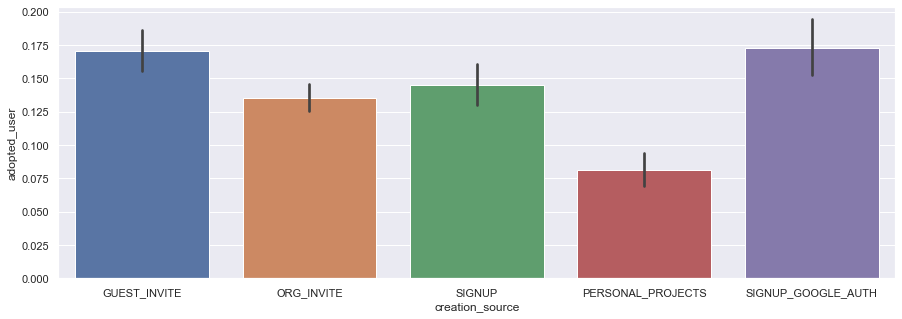

In [144]:
fig = plt.gcf()
fig.set_size_inches(15, 5)

sns.barplot(x='creation_source', y='adopted_user', data=df);

In [156]:
# since all of the above is 0 and 1, thet are of course not normally distributed

for i in list(df.creation_source.unique()):
    print(normality_test(df[df.creation_source==i].adopted_user))

P_value:  7.882932100619679e-131 < 0.05, reject null hypothese, this distribution is not normal
None
P_value:  0.0 < 0.05, reject null hypothese, this distribution is not normal
None
P_value:  5.349699096810418e-160 < 0.05, reject null hypothese, this distribution is not normal
None
P_value:  6.353019745953138e-282 < 0.05, reject null hypothese, this distribution is not normal
None
P_value:  4.006222704414966e-83 < 0.05, reject null hypothese, this distribution is not normal
None


In [163]:
mann_whitney_u(df[df.creation_source=='GUEST_INVITE'].adopted_user, df[df.creation_source=='SIGNUP_GOOGLE_AUTH'].adopted_user)
mann_whitney_u(df[df.creation_source=='GUEST_INVITE'].adopted_user, df[df.creation_source=='SIGNUP'].adopted_user)
mann_whitney_u(df[df.creation_source=='SIGNUP'].adopted_user, df[df.creation_source=='ORG_INVITE'].adopted_user)
mann_whitney_u(df[df.creation_source=='ORG_INVITE'].adopted_user, df[df.creation_source=='PERSONAL_PROJECTS'].adopted_user)


Cannot say x>y and x<y
P_value:  0.010337696565577514 < 0.05, x is greater than y
Cannot say x>y and x<y
P_value:  2.167335110241945e-10 < 0.05, x is greater than y


## 3.2 Opted in to mailing list VS adopted users

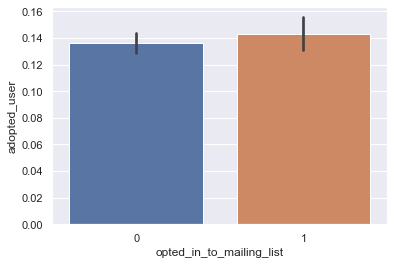

In [166]:
sns.barplot('opted_in_to_mailing_list', 'adopted_user', data=df);

In [167]:
mann_whitney_u(df[df.opted_in_to_mailing_list==0].adopted_user, df[df.opted_in_to_mailing_list==1].adopted_user)


Cannot say x>y and x<y


## 3.3 Enabled for marketing drip VS adopted users

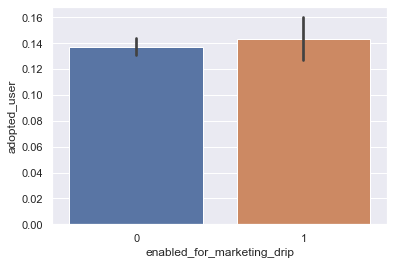

In [168]:
sns.barplot('enabled_for_marketing_drip', 'adopted_user', data=df);

In [169]:
mann_whitney_u(df[df.enabled_for_marketing_drip==0].adopted_user, df[df.enabled_for_marketing_drip==1].adopted_user)


Cannot say x>y and x<y


## 3.4 Org ID VS adopted users

Though there seems to be an upward trend of adopt users when the Org ID gets bigger, we cannot really say much from the plot.

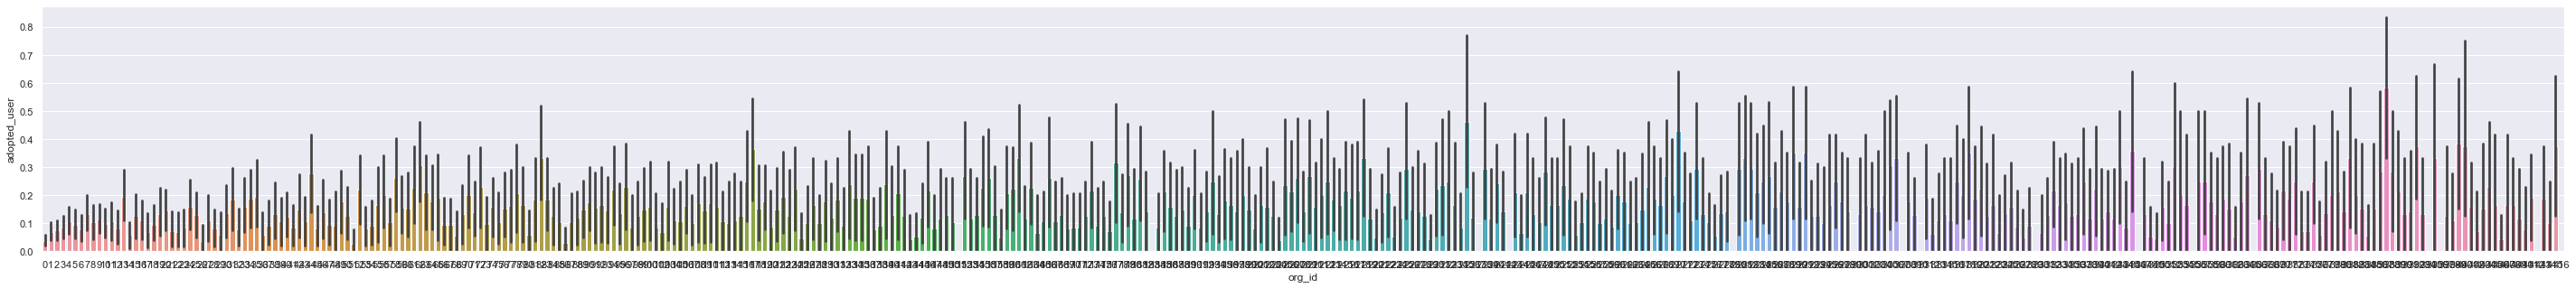

In [216]:
fig = plt.gcf()
fig.set_size_inches(50, 5)

sns.barplot('org_id', 'adopted_user', data=df);

## 3.5 Invited by user ID VS adopted user
For those who get invited by other users, have a higher chance to become an adopted user.

In [191]:
df['invited'] = 0

In [194]:
for i in tqdm(range(0, len(df))):
    if df.invited_by_user_id.iloc[i] != 0:
        df['invited'].iloc[i] = 1

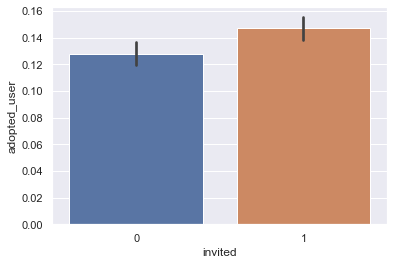

In [196]:
sns.barplot('invited', 'adopted_user', data=df);

In [197]:
mann_whitney_u(df[df.invited==0].adopted_user, df[df.invited==1].adopted_user)


P_value:  0.001149586497522916 < 0.05, x is less than y


## 3.6 Email Server VS adopted user


Thought those with company name as server, will have a higher adoption rate, but from the result, we can see that email servers with the highest adoption rate are gmail and hotmail.

In [268]:
email = df['email'].str.split("@", n = 1, expand = True)
df['email_server'] = email[1]

In [269]:
df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,email_server
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0,yahoo.com
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,gustr.com
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0,gustr.com
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0,yahoo.com
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0,yahoo.com


In [340]:
df.email_server.value_counts()[:10]

gmail.com         3562
yahoo.com         2447
jourrapide.com    1259
cuvox.de          1202
gustr.com         1179
hotmail.com       1165
xvnbr.com            2
luque.com            2
xybhi.com            2
mumdc.com            2
Name: email_server, dtype: int64

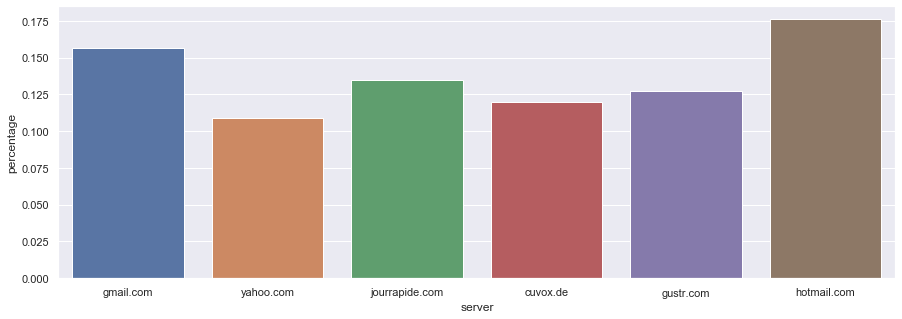

In [320]:
fig = plt.gcf()
fig.set_size_inches(15, 5)

most_used_server = ['gmail.com','yahoo.com','jourrapide.com','cuvox.de','gustr.com','hotmail.com'];

most_used_server_sum = [(df[df.email_server == 'gmail.com'].adopted_user.sum()/len(df[df.email_server == 'gmail.com'].adopted_user)),\
                        (df[df.email_server == 'yahoo.com'].adopted_user.sum()/len(df[df.email_server == 'yahoo.com'].adopted_user)),\
                        (df[df.email_server == 'jourrapide.com'].adopted_user.sum()/len(df[df.email_server == 'jourrapide.com'].adopted_user)),\
                        (df[df.email_server == 'cuvox.de'].adopted_user.sum()/len(df[df.email_server == 'cuvox.de'].adopted_user)),\
                        (df[df.email_server == 'gustr.com'].adopted_user.sum()/len(df[df.email_server == 'gustr.com'].adopted_user)),\
                        (df[df.email_server == 'hotmail.com'].adopted_user.sum()/len(df[df.email_server == 'hotmail.com'].adopted_user))]

server_df = pd.DataFrame({'server': most_used_server, 'percentage':most_used_server_sum})

sns.barplot('server', 'percentage', data=server_df);

In [318]:
mann_whitney_u(df[df.email_server == 'hotmail.com'].adopted_user, df[df.email_server == 'gmail.com'].adopted_user)
mann_whitney_u(df[df.email_server == 'gmail.com'].adopted_user, df[df.email_server == 'jourrapide.com'].adopted_user)
mann_whitney_u(df[df.email_server == 'jourrapide.com'].adopted_user, df[df.email_server == 'yahoo.com'].adopted_user)


Cannot say x>y and x<y
P_value:  0.0344551920335703 < 0.05, x is greater than y
P_value:  0.01026803158904461 < 0.05, x is greater than y


## 3.7 Active time interval VS adopted user

In [333]:
# Only way to make this interval withouts days work

df['active_interval'] = 0

for i in tqdm(range(0, len(df))):
    df['active_interval'].iloc[i] = (pd.to_datetime(df['last_session_creation_time'].iloc[i]) - pd.to_datetime(df['creation_time'].iloc[i])).days

    

In [334]:
df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,email_server,active_interval
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0,yahoo.com,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,gustr.com,136.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0,gustr.com,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0,yahoo.com,1.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0,yahoo.com,5.0


In [350]:
df.to_csv('ml.csv', index=False)

# 4.Machine learning

In [420]:
ml = pd.read_csv('ml.csv', index_col=False)

In [421]:
ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 13 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    12000 non-null object
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            12000 non-null float64
adopted_user                  12000 non-null int64
email_server                  12000 non-null object
active_interval               8823 non-null float64
dtypes: float64(2), int64(5), object(6)
memory usage: 1.2+ MB


In [422]:
for_ml = ml.drop(['object_id','creation_time','name','email','last_session_creation_time','email_server','creation_source'], axis=1)

In [423]:
for_ml.active_interval = for_ml.active_interval.astype(str).replace('nan', 0)

In [424]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

le_creation_source = le.fit_transform(df.creation_source)
le_email_server = le.fit_transform(df.email_server)

le_ml = pd.DataFrame({'creation_source': le_creation_source,\
                      'email_server': le_email_server})

train_test = for_ml.join(le_ml)

In [425]:
train_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 8 columns):
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            12000 non-null float64
adopted_user                  12000 non-null int64
active_interval               12000 non-null object
creation_source               12000 non-null int64
email_server                  12000 non-null int64
dtypes: float64(1), int64(6), object(1)
memory usage: 750.1+ KB


In [426]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
from sklearn import preprocessing
plt.rc("font", size=14)
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score



sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



pd.set_option('display.max_columns', None)

from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

## 4.1 Logistic regression

In [428]:
train = train_test.drop('adopted_user', axis=1)
test = train_test.adopted_user

In [429]:
X_train, X_test, y_train, y_test = train_test_split(train, test, random_state=0, test_size=0.2)

In [430]:
from sklearn.linear_model import LogisticRegression

In [431]:
lr = LogisticRegression(random_state=0)
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [432]:
y_pred = lr.predict(X_test)

In [433]:
lr_cv_score = cross_val_score(lr, X_train, y_train, cv=5, scoring='roc_auc')
lr_cv_score1 = cross_val_score(lr, X_train, y_train, cv=5, scoring='f1')



In [434]:
print("=== f1 score on test===")
print(f1_score(y_test, y_pred))
print('\n')
print("=== Confusion Matrix on test===")
print(confusion_matrix(y_test, y_pred))
print('\n')
print("=== Classification Report on test===")
print(classification_report(y_test, y_pred))
print('\n')
print("=== All AUC Scores on CV===")
print(lr_cv_score)
print('\n')
print("=== Mean AUC Score on CV===")
print("Mean AUC Score: ", lr_cv_score.mean())
print('\n')
print("=== All f1 Scores on CV===")
print(lr_cv_score1)
print('\n')
print("=== Mean f1 Score on CV===")
print("Mean f1 Score: ", lr_cv_score1.mean())

=== f1 score on test===
0.8610169491525423


=== Confusion Matrix on test===
[[2064   23]
 [  59  254]]


=== Classification Report on test===
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2087
           1       0.92      0.81      0.86       313

    accuracy                           0.97      2400
   macro avg       0.94      0.90      0.92      2400
weighted avg       0.97      0.97      0.96      2400



=== All AUC Scores on CV===
[0.99623977 0.98951367 0.99261009 0.99354304 0.97473942]


=== Mean AUC Score on CV===
Mean AUC Score:  0.989329196297755


=== All f1 Scores on CV===
[0.91746641 0.90909091 0.88362919 0.91828794 0.90225564]


=== Mean f1 Score on CV===
Mean f1 Score:  0.9061460176003806


In [435]:
coef = pd.DataFrame(lr.coef_).T

In [436]:
coef.set_index(X_train.columns).sort_values(0, ascending=False)

,0
opted_in_to_mailing_list,0.303483
enabled_for_marketing_drip,0.068769
active_interval,0.066083
org_id,0.000536
invited_by_user_id,0.000028
email_server,-0.000780
creation_source,-0.058749


## 4.2 Random Forest Regressor

In [437]:
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier

In [443]:
rfc = RandomForestClassifier(random_state=0)

In [446]:
parameters = {'random_state':[0], 'max_depth': [10 ,11, 12], 'n_estimators': [90, 100, 110], 'max_features':['auto']}
rfc_cv = GridSearchCV(rfc, param_grid=parameters, cv=5)
rfc_cv.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=0,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'m

In [447]:
rfc_cv.best_params_

{'max_depth': 11,
 'max_features': 'auto',
 'n_estimators': 100,
 'random_state': 0}

In [448]:
rfc_best = RandomForestClassifier(random_state=0, max_depth=11, max_features='auto', n_estimators=100)

In [451]:
rfc_best.fit(X_train, y_train)
rfc_predict = rfc_best.predict(X_test)


In [452]:
rfc_cv_score = cross_val_score(rfc_best, X_train, y_train, cv=5, scoring='roc_auc')
rfc_cv_score1 = cross_val_score(rfc_best, X_train, y_train, cv=5, scoring='f1')




In [453]:
print("=== f1 score on test===")
print(f1_score(y_test, rfc_predict))
print('\n')
print("=== Confusion Matrix on test===")
print(confusion_matrix(y_test, rfc_predict))
print('\n')
print("=== Classification Report on test===")
print(classification_report(y_test, rfc_predict))
print('\n')
print("=== All AUC Scores on CV===")
print(rfc_cv_score)
print('\n')
print("=== Mean AUC Score on CV===")
print("Mean AUC Score: ", rfc_cv_score.mean())
print('\n')
print("=== All f1 Scores on CV===")
print(rfc_cv_score1)
print('\n')
print("=== Mean f1 Score on CV===")
print("Mean f1 Score: ", rfc_cv_score1.mean())

=== f1 score on test===
0.8571428571428572


=== Confusion Matrix on test===
[[2064   23]
 [  61  252]]


=== Classification Report on test===
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2087
           1       0.92      0.81      0.86       313

    accuracy                           0.96      2400
   macro avg       0.94      0.90      0.92      2400
weighted avg       0.96      0.96      0.96      2400



=== All AUC Scores on CV===
[0.9935158  0.99361369 0.98895791 0.99246951 0.99250793]


=== Mean AUC Score on CV===
Mean AUC Score:  0.9922129699149391


=== All f1 Scores on CV===
[0.92337165 0.90384615 0.89019608 0.91891892 0.89433962]


=== Mean f1 Score on CV===
Mean f1 Score:  0.9061344842695067


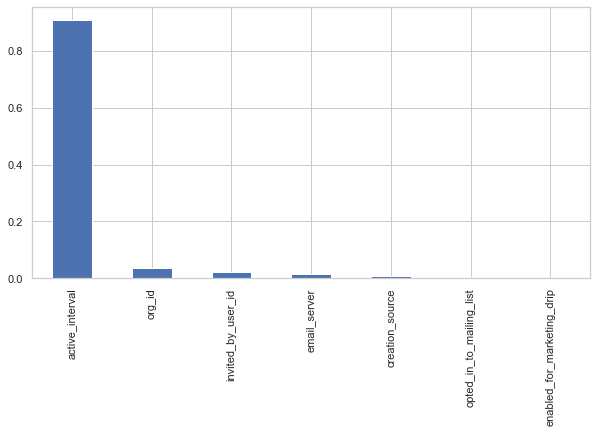

In [455]:
fig = plt.gcf();
fig.set_size_inches(10, 5);

feat_importances = pd.Series(rfc_best.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='bar');

# 5. Conclusion:
It is really impressive to reach the score of 0.90 by using random forest regressor, from the feature importance plot, this is because the added variable: active_interval, this column have helped to detect adopted user. 